In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('Output/Modelling', exist_ok=True)
os.makedirs('Output/Modelling/Plots', exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

ASEAN5_COUNTRIES = ['Indonesia', 'Malaysia', 'Filipina', 'Singapura', 'Thailand']


In [2]:
df = pd.read_csv("Data/panel_asean5_cleaned.csv")
print(f"Data loaded: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()


Data loaded: (150, 20)
Columns: ['year', 'exchange_rate', 'Corruption Perception Index', 'gdp_growth', 'ca_gdp', 'infl_diff', 'reserves_moi', 'country', 'log_exchange_rate', 'depreciation', 'lreserves_moi', 'corr_inv', 'corr_inv_l1', 'infl_diff_l1', 'ca_gdp_l1', 'reserves_moi_l1', 'gdp_growth_l1', 'AFC_97_98', 'GFC_08_09', 'COVID_20_22']


,year,exchange_rate,Corruption Perception Index,gdp_growth,ca_gdp,infl_diff,reserves_moi,country,log_exchange_rate,depreciation,lreserves_moi,corr_inv,corr_inv_l1,infl_diff_l1,ca_gdp_l1,reserves_moi_l1,gdp_growth_l1,AFC_97_98,GFC_08_09,COVID_20_22
0,1995.0,25.6763,27.7,4.625225,-2.339200,6.831996,2.613809,Filipina,3.245568,NaN,0.960809,72.3,NaN,NaN,NaN,NaN,NaN,0,0,0
1,1996.0,26.2028,26.9,5.860348,-4.176524,7.476104,3.204902,Filipina,3.265866,0.020298,1.164681,73.1,72.3,6.831996,-2.339200,2.613809,4.625225,0,0,0
2,1997.0,29.5693,30.5,5.186412,-4.623494,5.590259,1.961715,Filipina,3.386737,0.120870,0.673819,69.5,73.1,7.476104,-4.176524,3.204902,5.860348,1,0,0
3,1998.0,40.7572,33.0,-0.514090,2.075379,9.234934,3.074316,Filipina,3.707633,0.320896,1.123082,67.0,69.5,5.590259,-4.623494,1.961715,5.186412,1,0,0
4,1999.0,39.0886,36.0,3.346451,-3.357069,5.939049,5.172271,Filipina,3.665831,-0.041802,1.643312,64.0,67.0,9.234934,2.075379,3.074316,-0.514090,0,0,0


# Dokumentasi Keputusan Perlakuan Variabel

Berdasarkan hasil unit root tests, dokumentasikan keputusan final untuk setiap variabel.


In [3]:
variable_treatment = pd.DataFrame({
    'Variable': [
        'depreciation',
        'corr_inv_l1',
        'infl_diff_l1',
        'gdp_growth_l1',
        'ca_gdp_l1',
        'reserves_moi_l1',
        'AFC_97_98',
        'GFC_08_09',
        'COVID_20_22'
    ],
    'Definition': [
        'log(ER_t) - log(ER_{t-1})',
        'Corruption index (inverted CPI), lag 1 year',
        'Inflation differential, lag 1 year',
        'GDP growth (%), lag 1 year',
        'Current account balance (% of GDP), lag 1 year',
        'Total reserves in months of imports, lag 1 year',
        'Asian Financial Crisis dummy (1997-1998)',
        'Global Financial Crisis dummy (2008-2009)',
        'COVID-19 Pandemic dummy (2020-2022)'
    ],
    'ADF_Result': [
        'Stasioner I(0) di level untuk semua negara',
        'Campuran: Indonesia I(1), Thailand & Malaysia I(0)',
        'Umumnya stasioner di level',
        'Umumnya stasioner di level',
        'Indikasi unit root di sebagian negara',
        'Indikasi unit root di sebagian negara',
        'Dummy variable',
        'Dummy variable',
        'Dummy variable'
    ],
    'Decision': [
        'Dipertahankan dalam level (tidak perlu differencing)',
        'Pakai level lagged dengan caveat: risiko unit root dikurangi oleh FE dan dummy krisis',
        'Pakai level lagged tanpa modifikasi',
        'Pakai level lagged tanpa modifikasi',
        'Model utama: level lagged. Robustness: Δca_gdp_l1',
        'Model utama: level lagged. Robustness: Δreserves_moi_l1',
        'Masuk model final (signifikan, R² naik besar)',
        'Masuk model final (signifikan, R² naik besar)',
        'Masuk model final (signifikan, R² naik besar)'
    ],
    'Justification': [
        'Hasil ADF menunjukkan stasioner di level untuk semua negara',
        'Indeks dibatasi dalam range tertentu, tertarik pada level korupsi, bukan perubahan tahunan',
        'Hasil ADF menunjukkan stasioner di level',
        'Hasil ADF menunjukkan stasioner di level',
        'Interpretasi ekonomi jelas: posisi eksternal. Robustness dengan differencing',
        'Interpretasi ekonomi jelas: buffer cadangan. Robustness dengan differencing',
        'Secara statistik signifikan dan ekonomi masuk akal sebagai shock bersama',
        'Secara statistik signifikan dan ekonomi masuk akal sebagai shock bersama',
        'Secara statistik signifikan dan ekonomi masuk akal sebagai shock bersama'
    ]
})

print("KEPUTUSAN PERLAKUAN VARIABEL")
print("="*80)
display(variable_treatment)

variable_treatment.to_csv('Output/Modelling/variable_treatment_decision.csv', index=False)
variable_treatment.to_excel('Output/Modelling/variable_treatment_decision.xlsx', index=False)
print("\n✓ Tabel keputusan perlakuan variabel disimpan ke:")
print("  - Output/Modelling/variable_treatment_decision.csv")
print("  - Output/Modelling/variable_treatment_decision.xlsx")


KEPUTUSAN PERLAKUAN VARIABEL


,Variable,Definition,ADF_Result,Decision,Justification
0,depreciation,log(ER_t) - log(ER_{t-1}),Stasioner I(0) di level untuk semua negara,Dipertahankan dalam level (tidak perlu differe...,Hasil ADF menunjukkan stasioner di level untuk...
1,corr_inv_l1,"Corruption index (inverted CPI), lag 1 year","Campuran: Indonesia I(1), Thailand & Malaysia ...",Pakai level lagged dengan caveat: risiko unit ...,"Indeks dibatasi dalam range tertentu, tertarik..."
2,infl_diff_l1,"Inflation differential, lag 1 year",Umumnya stasioner di level,Pakai level lagged tanpa modifikasi,Hasil ADF menunjukkan stasioner di level
3,gdp_growth_l1,"GDP growth (%), lag 1 year",Umumnya stasioner di level,Pakai level lagged tanpa modifikasi,Hasil ADF menunjukkan stasioner di level
4,ca_gdp_l1,"Current account balance (% of GDP), lag 1 year",Indikasi unit root di sebagian negara,Model utama: level lagged. Robustness: Δca_gdp_l1,Interpretasi ekonomi jelas: posisi eksternal. ...
5,reserves_moi_l1,"Total reserves in months of imports, lag 1 year",Indikasi unit root di sebagian negara,Model utama: level lagged. Robustness: Δreserv...,Interpretasi ekonomi jelas: buffer cadangan. R...
6,AFC_97_98,Asian Financial Crisis dummy (1997-1998),Dummy variable,"Masuk model final (signifikan, R² naik besar)",Secara statistik signifikan dan ekonomi masuk ...
7,GFC_08_09,Global Financial Crisis dummy (2008-2009),Dummy variable,"Masuk model final (signifikan, R² naik besar)",Secara statistik signifikan dan ekonomi masuk ...
8,COVID_20_22,COVID-19 Pandemic dummy (2020-2022),Dummy variable,"Masuk model final (signifikan, R² naik besar)",Secara statistik signifikan dan ekonomi masuk ...



✓ Tabel keputusan perlakuan variabel disimpan ke:
  - Output/Modelling/variable_treatment_decision.csv
  - Output/Modelling/variable_treatment_decision.xlsx


# Blok Model Utama: Depresiasi vs Korupsi

## Model 0: POLS Sederhana (Baseline Naïf)


In [4]:
DEPENDENT_VAR = 'depreciation'
INDEPENDENT_VARS = ['corr_inv_l1', 'infl_diff_l1', 'ca_gdp_l1', 'reserves_moi_l1', 'gdp_growth_l1']

data_model = df[[DEPENDENT_VAR, 'country', 'year'] + INDEPENDENT_VARS].dropna()
print(f"Data untuk estimasi: {data_model.shape}")
print(f"Countries: {data_model['country'].unique()}")
print(f"Year range: {data_model['year'].min()} - {data_model['year'].max()}")


Data untuk estimasi: (145, 8)
Countries: ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']
Year range: 1996.0 - 2024.0


In [5]:
y = data_model[DEPENDENT_VAR]
X = data_model[['corr_inv_l1']]
X = sm.add_constant(X)

model_0 = OLS(y, X)
results_0 = model_0.fit(cov_type='cluster', cov_kwds={'groups': data_model['country']})

print("MODEL 0: POLS Sederhana (Baseline Naïf)")
print("="*80)
print("depreciation = β₀ + β₁ corr_inv_l1 + u")
print("\n")
display(results_0.summary())

results_0_df = pd.DataFrame({
    'Variable': ['const', 'corr_inv_l1'],
    'Coefficient': results_0.params.values,
    'Std_Error': results_0.bse.values,
    'P_value': results_0.pvalues.values,
    'Model': 'Model_0_POLS_Baseline',
    'R_squared': results_0.rsquared,
    'N_obs': results_0.nobs
})

results_0_df.to_csv('Output/Modelling/Model_0_POLS_Baseline.csv', index=False)
print("\n✓ Hasil Model 0 disimpan ke: Output/Modelling/Model_0_POLS_Baseline.csv")


MODEL 0: POLS Sederhana (Baseline Naïf)
depreciation = β₀ + β₁ corr_inv_l1 + u




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.872
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0485
Time:                        08:36:32   Log-Likelihood:                 92.022
No. Observations:                 145   AIC:                            -180.0
Df Residuals:                     143   BIC:                            -174.1
Df Model:                           1                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0107      0.005     -2.089      0.037      -0.021      -0.001
corr_inv_l1     0.0007      0.000      2.806      0.005       0.000       0.001
==============================================================================
Omnibus:                      217.990   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19514.180
Skew:                           6.133   Prob(JB):                         0.00
Kurtosis:                      58.493   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


✓ Hasil Model 0 disimpan ke: Output/Modelling/Model_0_POLS_Baseline.csv


## Model 1: POLS dengan Kontrol Makro


In [6]:
y = data_model[DEPENDENT_VAR]
X = data_model[INDEPENDENT_VARS]
X = sm.add_constant(X)

model_1 = OLS(y, X)
results_1 = model_1.fit(cov_type='cluster', cov_kwds={'groups': data_model['country']})

print("MODEL 1: POLS dengan Kontrol Makro")
print("="*80)
print("depreciation = β₀ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1 + u")
print("\n")
display(results_1.summary())

results_1_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS,
    'Coefficient': results_1.params.values,
    'Std_Error': results_1.bse.values,
    'P_value': results_1.pvalues.values,
    'Model': 'Model_1_POLS_Controls',
    'R_squared': results_1.rsquared,
    'N_obs': results_1.nobs
})

results_1_df.to_csv('Output/Modelling/Model_1_POLS_Controls.csv', index=False)
print("\n✓ Hasil Model 1 disimpan ke: Output/Modelling/Model_1_POLS_Controls.csv")


MODEL 1: POLS dengan Kontrol Makro
depreciation = β₀ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1 + u




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     17.32
Date:                Thu, 04 Dec 2025   Prob (F-statistic):            0.00862
Time:                        08:36:32   Log-Likelihood:                 105.12
No. Observations:                 145   AIC:                            -198.2
Df Residuals:                     139   BIC:                            -180.4
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2112      0.053      3.948      0.000       0.106       0.316
corr_inv_l1        -0.0005      0.001     -0.526      0.599      -0.002       0.001
infl_diff_l1       -0.0043      0.002     -2.352      0.019      -0.008      -0.001
ca_gdp_l1          -0.0062      0.001     -4.630      0.000      -0.009      -0.004
reserves_moi_l1    -0.0179      0.013     -1.376      0.169      -0.043       0.008
gdp_growth_l1      -0.0001      0.002     -0.058      0.954      -0.004       0.004
==============================================================================
Omnibus:                      227.502   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24311.055
Skew:                           6.558   Prob(JB):                         0.00
Kurtosis:                      65.063   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


✓ Hasil Model 1 disimpan ke: Output/Modelling/Model_1_POLS_Controls.csv


## Model 2: Fixed Effects Satu Arah (Country FE)


In [7]:
data_fem1 = data_model.copy()
data_demeaned = data_fem1.copy()

for var in [DEPENDENT_VAR] + INDEPENDENT_VARS:
    means = data_fem1.groupby('country')[var].transform('mean')
    data_demeaned[var] = data_fem1[var] - means

y_fem1 = data_demeaned[DEPENDENT_VAR]
X_fem1 = data_demeaned[INDEPENDENT_VARS]
X_fem1 = sm.add_constant(X_fem1)

model_2 = OLS(y_fem1, X_fem1)
results_2 = model_2.fit(cov_type='cluster', cov_kwds={'groups': data_fem1['country']})

print("MODEL 2: Fixed Effects Satu Arah (Country FE)")
print("="*80)
print("depreciation = αᵢ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1 + ε")
print("\n")
display(results_2.summary())

country_effects_2 = {}
for country in data_fem1['country'].unique():
    country_data = data_fem1[data_fem1['country'] == country]
    if len(country_data) > 0:
        y_mean = country_data[DEPENDENT_VAR].mean()
        x_means = country_data[INDEPENDENT_VARS].mean()
        intercept = y_mean - np.dot(x_means, results_2.params[1:])
        country_effects_2[country] = intercept

print("\nCountry Fixed Effects:")
for country, effect in country_effects_2.items():
    print(f"  {country}: {effect:.4f}")

results_2_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS,
    'Coefficient': results_2.params.values,
    'Std_Error': results_2.bse.values,
    'P_value': results_2.pvalues.values,
    'Model': 'Model_2_FE_Country',
    'R_squared': results_2.rsquared,
    'N_obs': results_2.nobs
})

results_2_df.to_csv('Output/Modelling/Model_2_FE_Country.csv', index=False)

country_fe_df = pd.DataFrame(list(country_effects_2.items()), columns=['Country', 'Fixed_Effect'])
country_fe_df.to_csv('Output/Modelling/Model_2_Country_FE.csv', index=False)

print("\n✓ Hasil Model 2 disimpan ke:")
print("  - Output/Modelling/Model_2_FE_Country.csv")
print("  - Output/Modelling/Model_2_Country_FE.csv")


MODEL 2: Fixed Effects Satu Arah (Country FE)
depreciation = αᵢ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1 + ε




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     12.14
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0165
Time:                        08:36:32   Log-Likelihood:                 107.44
No. Observations:                 145   AIC:                            -202.9
Df Residuals:                     139   BIC:                            -185.0
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.493e-18   7.21e-18      0.484      0.628   -1.06e-17    1.76e-17
corr_inv_l1         0.0010      0.002      0.676      0.499      -0.002       0.004
infl_diff_l1       -0.0063      0.002     -3.500      0.000      -0.010      -0.003
ca_gdp_l1          -0.0066      0.002     -3.967      0.000      -0.010      -0.003
reserves_moi_l1    -0.0170      0.012     -1.364      0.172      -0.041       0.007
gdp_growth_l1      -0.0010      0.003     -0.375      0.708      -0.006       0.004
==============================================================================
Omnibus:                      222.244   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21852.112
Skew:                           6.311   Prob(JB):                         0.00
Kurtosis:                      61.801   Cond. No.                         5.75
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


Country Fixed Effects:
  Filipina: 0.1107
  Indonesia: 0.1474
  Malaysia: 0.1212
  Singapura: 0.2153
  Thailand: 0.0976

✓ Hasil Model 2 disimpan ke:
  - Output/Modelling/Model_2_FE_Country.csv
  - Output/Modelling/Model_2_Country_FE.csv


## Model 3: Fixed Effects Dua Arah (Country + Time FE) - MODEL UTAMA


In [8]:
data_fem2 = data_model.copy()
data_demeaned2 = data_fem2.copy()

for var in [DEPENDENT_VAR] + INDEPENDENT_VARS:
    country_means = data_fem2.groupby('country')[var].transform('mean')
    time_means = data_fem2.groupby('year')[var].transform('mean')
    grand_mean = data_fem2[var].mean()
    data_demeaned2[var] = data_fem2[var] - country_means - time_means + grand_mean

y_fem2 = data_demeaned2[DEPENDENT_VAR]
X_fem2 = data_demeaned2[INDEPENDENT_VARS]
X_fem2 = sm.add_constant(X_fem2)

model_3 = OLS(y_fem2, X_fem2)
results_3 = model_3.fit(cov_type='cluster', cov_kwds={'groups': data_fem2['country']})

print("MODEL 3: Fixed Effects Dua Arah (Country + Time FE) - MODEL UTAMA")
print("="*80)
print("depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1 + ε")
print("\n")
display(results_3.summary())

country_effects_3 = {}
for country in data_fem2['country'].unique():
    country_data = data_fem2[data_fem2['country'] == country]
    if len(country_data) > 0:
        y_mean = country_data[DEPENDENT_VAR].mean()
        x_means = country_data[INDEPENDENT_VARS].mean()
        intercept = y_mean - np.dot(x_means, results_3.params[1:])
        country_effects_3[country] = intercept

time_effects_3 = {}
for year in data_fem2['year'].unique():
    year_data = data_fem2[data_fem2['year'] == year]
    if len(year_data) > 0:
        y_mean = year_data[DEPENDENT_VAR].mean()
        x_means = year_data[INDEPENDENT_VARS].mean()
        intercept = y_mean - np.dot(x_means, results_3.params[1:])
        time_effects_3[year] = intercept

print("\nCountry Fixed Effects:")
for country, effect in country_effects_3.items():
    print(f"  {country}: {effect:.4f}")

results_3_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS,
    'Coefficient': results_3.params.values,
    'Std_Error': results_3.bse.values,
    'P_value': results_3.pvalues.values,
    'Model': 'Model_3_FE_TwoWay',
    'R_squared': results_3.rsquared,
    'N_obs': results_3.nobs
})

results_3_df.to_csv('Output/Modelling/Model_3_FE_TwoWay.csv', index=False)

country_fe3_df = pd.DataFrame(list(country_effects_3.items()), columns=['Country', 'Fixed_Effect'])
country_fe3_df.to_csv('Output/Modelling/Model_3_Country_FE.csv', index=False)

time_fe3_df = pd.DataFrame(list(time_effects_3.items()), columns=['Year', 'Fixed_Effect'])
time_fe3_df.to_csv('Output/Modelling/Model_3_Time_FE.csv', index=False)

print("\n✓ Hasil Model 3 disimpan ke:")
print("  - Output/Modelling/Model_3_FE_TwoWay.csv")
print("  - Output/Modelling/Model_3_Country_FE.csv")
print("  - Output/Modelling/Model_3_Time_FE.csv")


MODEL 3: Fixed Effects Dua Arah (Country + Time FE) - MODEL UTAMA
depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1 + ε




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     89.91
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000360
Time:                        08:36:32   Log-Likelihood:                 164.76
No. Observations:                 145   AIC:                            -317.5
Df Residuals:                     139   BIC:                            -299.7
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.982e-19   3.21e-18     -0.093      0.926   -6.58e-18    5.99e-18
corr_inv_l1         0.0007      0.001      0.493      0.622      -0.002       0.004
infl_diff_l1       -0.0068      0.001     -7.139      0.000      -0.009      -0.005
ca_gdp_l1          -0.0005      0.002     -0.245      0.806      -0.004       0.003
reserves_moi_l1    -0.0052      0.007     -0.714      0.475      -0.019       0.009
gdp_growth_l1      -0.0045      0.004     -1.175      0.240      -0.012       0.003
==============================================================================
Omnibus:                      205.846   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19773.575
Skew:                           5.446   Prob(JB):                         0.00
Kurtosis:                      59.162   Cond. No.                         4.90
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


Country Fixed Effects:
  Filipina: 0.0655
  Indonesia: 0.1214
  Malaysia: 0.0519
  Singapura: 0.0609
  Thailand: 0.0320

✓ Hasil Model 3 disimpan ke:
  - Output/Modelling/Model_3_FE_TwoWay.csv
  - Output/Modelling/Model_3_Country_FE.csv
  - Output/Modelling/Model_3_Time_FE.csv


## Model 3 dengan Dummy Krisis


In [9]:
crisis_dummies = ['AFC_97_98', 'GFC_08_09', 'COVID_20_22']
all_vars_crisis = [DEPENDENT_VAR, 'country', 'year'] + INDEPENDENT_VARS + [d for d in crisis_dummies if d in df.columns]
data_crisis = df[all_vars_crisis].dropna()

data_demeaned_crisis = data_crisis.copy()
for var in [DEPENDENT_VAR] + INDEPENDENT_VARS + [d for d in crisis_dummies if d in df.columns]:
    country_means = data_crisis.groupby('country')[var].transform('mean')
    time_means = data_crisis.groupby('year')[var].transform('mean')
    grand_mean = data_crisis[var].mean()
    data_demeaned_crisis[var] = data_crisis[var] - country_means - time_means + grand_mean

y_crisis = data_demeaned_crisis[DEPENDENT_VAR]
X_crisis = data_demeaned_crisis[INDEPENDENT_VARS + [d for d in crisis_dummies if d in df.columns]]
X_crisis = sm.add_constant(X_crisis)

model_3_crisis = OLS(y_crisis, X_crisis)
results_3_crisis = model_3_crisis.fit(cov_type='cluster', cov_kwds={'groups': data_crisis['country']})

print("MODEL 3 dengan Dummy Krisis")
print("="*80)
print("depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1")
print("              + β₆ AFC_97_98 + β₇ GFC_08_09 + β₈ COVID_20_22 + ε")
print("\n")
display(results_3_crisis.summary())

results_3_crisis_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS + [d for d in crisis_dummies if d in df.columns],
    'Coefficient': results_3_crisis.params.values,
    'Std_Error': results_3_crisis.bse.values,
    'P_value': results_3_crisis.pvalues.values,
    'Model': 'Model_3_FE_TwoWay_Crisis',
    'R_squared': results_3_crisis.rsquared,
    'N_obs': results_3_crisis.nobs
})

results_3_crisis_df.to_csv('Output/Modelling/Model_3_FE_TwoWay_Crisis.csv', index=False)
print("\n✓ Hasil Model 3 dengan Dummy Krisis disimpan ke: Output/Modelling/Model_3_FE_TwoWay_Crisis.csv")


MODEL 3 dengan Dummy Krisis
depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ ca_gdp_l1 + β₄ reserves_moi_l1 + β₅ gdp_growth_l1
              + β₆ AFC_97_98 + β₇ GFC_08_09 + β₈ COVID_20_22 + ε




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     87.97
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000376
Time:                        08:36:32   Log-Likelihood:                 164.76
No. Observations:                 145   AIC:                            -317.5
Df Residuals:                     139   BIC:                            -299.7
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.982e-19    4.1e-18     -0.073      0.942   -8.33e-18    7.73e-18
corr_inv_l1         0.0007      0.001      0.488      0.626      -0.002       0.004
infl_diff_l1       -0.0068      0.001     -7.061      0.000      -0.009      -0.005
ca_gdp_l1          -0.0005      0.002     -0.243      0.808      -0.005       0.004
reserves_moi_l1    -0.0052      0.007     -0.707      0.480      -0.020       0.009
gdp_growth_l1      -0.0045      0.004     -1.162      0.245      -0.012       0.003
AFC_97_98        1.222e-19   8.89e-20      1.374      0.169   -5.21e-20    2.96e-19
GFC_08_09       -6.919e-20   4.83e-20     -1.433      0.152   -1.64e-19    2.55e-20
COVID_20_22      9.493e-20   6.86e-20      1.383      0.167   -3.96e-20    2.29e-19
==============================================================================
Omnibus:                      205.846   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19773.575
Skew:                           5.446   Prob(JB):                         0.00
Kurtosis:                      59.162   Cond. No.                     1.18e+18
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.51e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


✓ Hasil Model 3 dengan Dummy Krisis disimpan ke: Output/Modelling/Model_3_FE_TwoWay_Crisis.csv


# Blok Model Interaksi / Heterogenitas

## Model 5: Interaksi Korupsi × Tier Korupsi


In [10]:
corr_means = data_model.groupby('country')['corr_inv_l1'].mean().sort_values()
print("Rata-rata corr_inv per negara:")
print(corr_means)

tier1_threshold = corr_means.quantile(0.33)
tier2_threshold = corr_means.quantile(0.67)

data_tier = data_model.copy()
data_tier['tier'] = pd.cut(data_tier.groupby('country')['corr_inv_l1'].transform('mean'), 
                           bins=[-np.inf, tier1_threshold, tier2_threshold, np.inf],
                           labels=['Tier1_Low', 'Tier2_Medium', 'Tier3_High'])

data_tier['tier2'] = (data_tier['tier'] == 'Tier2_Medium').astype(int)
data_tier['tier3'] = (data_tier['tier'] == 'Tier3_High').astype(int)

data_tier['corr_tier2'] = data_tier['corr_inv_l1'] * data_tier['tier2']
data_tier['corr_tier3'] = data_tier['corr_inv_l1'] * data_tier['tier3']

print(f"\nTier distribution:")
print(data_tier.groupby('country')['tier'].first())

data_demeaned_tier = data_tier.copy()
for var in [DEPENDENT_VAR] + INDEPENDENT_VARS + ['corr_tier2', 'corr_tier3']:
    country_means = data_tier.groupby('country')[var].transform('mean')
    time_means = data_tier.groupby('year')[var].transform('mean')
    grand_mean = data_tier[var].mean()
    data_demeaned_tier[var] = data_tier[var] - country_means - time_means + grand_mean

y_tier = data_demeaned_tier[DEPENDENT_VAR]
X_tier = data_demeaned_tier[INDEPENDENT_VARS + ['corr_tier2', 'corr_tier3']]
X_tier = sm.add_constant(X_tier)

model_5 = OLS(y_tier, X_tier)
results_5 = model_5.fit(cov_type='cluster', cov_kwds={'groups': data_tier['country']})

print("\nMODEL 5: Interaksi Korupsi × Tier Korupsi")
print("="*80)
print("depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ (corr_inv_l1 × Tier2) + β₃ (corr_inv_l1 × Tier3) + kontrol + ε")
print("\n")
display(results_5.summary())

print("\nInterpretasi:")
print(f"  Efek korupsi di Tier1 (Low): {results_5.params['corr_inv_l1']:.4f}")
print(f"  Efek korupsi di Tier2 (Medium): {results_5.params['corr_inv_l1'] + results_5.params['corr_tier2']:.4f}")
print(f"  Efek korupsi di Tier3 (High): {results_5.params['corr_inv_l1'] + results_5.params['corr_tier3']:.4f}")

results_5_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS + ['corr_tier2', 'corr_tier3'],
    'Coefficient': results_5.params.values,
    'Std_Error': results_5.bse.values,
    'P_value': results_5.pvalues.values,
    'Model': 'Model_5_Interaction_Tier',
    'R_squared': results_5.rsquared,
    'N_obs': results_5.nobs
})

results_5_df.to_csv('Output/Modelling/Model_5_Interaction_Tier.csv', index=False)
print("\n✓ Hasil Model 5 disimpan ke: Output/Modelling/Model_5_Interaction_Tier.csv")


Rata-rata corr_inv per negara:
country
Singapura    11.096552
Malaysia     50.444828
Thailand     65.593103
Filipina     69.789655
Indonesia    71.927586
Name: corr_inv_l1, dtype: float64

Tier distribution:
country
Filipina       Tier3_High
Indonesia      Tier3_High
Malaysia        Tier1_Low
Singapura       Tier1_Low
Thailand     Tier2_Medium
Name: tier, dtype: category
Categories (3, object): ['Tier1_Low' < 'Tier2_Medium' < 'Tier3_High']

MODEL 5: Interaksi Korupsi × Tier Korupsi
depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ (corr_inv_l1 × Tier2) + β₃ (corr_inv_l1 × Tier3) + kontrol + ε




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.302
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.402
Time:                        08:36:32   Log-Likelihood:                 166.11
No. Observations:                 145   AIC:                            -316.2
Df Residuals:                     137   BIC:                            -292.4
Df Model:                           7                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.982e-19   1.52e-17     -0.020      0.984   -3.01e-17    2.95e-17
corr_inv_l1        -0.0045      0.004     -1.143      0.253      -0.012       0.003
infl_diff_l1       -0.0073      0.001     -5.813      0.000      -0.010      -0.005
ca_gdp_l1          -0.0003      0.002     -0.134      0.894      -0.005       0.004
reserves_moi_l1    -0.0072      0.009     -0.827      0.408      -0.024       0.010
gdp_growth_l1      -0.0046      0.005     -1.016      0.309      -0.013       0.004
corr_tier2          0.0049      0.008      0.650      0.516      -0.010       0.020
corr_tier3          0.0077      0.005      1.498      0.134      -0.002       0.018
==============================================================================
Omnibus:                      206.843   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19881.570
Skew:                           5.497   Prob(JB):                         0.00
Kurtosis:                      59.302   Cond. No.                         8.29
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


Interpretasi:
  Efek korupsi di Tier1 (Low): -0.0045
  Efek korupsi di Tier2 (Medium): 0.0004
  Efek korupsi di Tier3 (High): 0.0033

✓ Hasil Model 5 disimpan ke: Output/Modelling/Model_5_Interaction_Tier.csv


## Model 6: Interaksi Korupsi × Krisis

In [11]:
data_crisis_int = data_crisis.copy()
data_crisis_int['crisis_combined'] = ((data_crisis_int['AFC_97_98'] == 1) | 
                                       (data_crisis_int['GFC_08_09'] == 1) | 
                                       (data_crisis_int['COVID_20_22'] == 1)).astype(int)

data_crisis_int['corr_crisis'] = data_crisis_int['corr_inv_l1'] * data_crisis_int['crisis_combined']

data_demeaned_crisis_int = data_crisis_int.copy()
for var in [DEPENDENT_VAR] + INDEPENDENT_VARS + ['crisis_combined', 'corr_crisis']:
    country_means = data_crisis_int.groupby('country')[var].transform('mean')
    time_means = data_crisis_int.groupby('year')[var].transform('mean')
    grand_mean = data_crisis_int[var].mean()
    data_demeaned_crisis_int[var] = data_crisis_int[var] - country_means - time_means + grand_mean

y_crisis_int = data_demeaned_crisis_int[DEPENDENT_VAR]
X_crisis_int = data_demeaned_crisis_int[INDEPENDENT_VARS + ['crisis_combined', 'corr_crisis']]
X_crisis_int = sm.add_constant(X_crisis_int)

model_6 = OLS(y_crisis_int, X_crisis_int)
results_6 = model_6.fit(cov_type='cluster', cov_kwds={'groups': data_crisis_int['country']})

print("MODEL 6: Interaksi Korupsi × Krisis")
print("="*80)
print("depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ Crisis + β₃ (corr_inv_l1 × Crisis) + kontrol + ε")
print("\n")
display(results_6.summary())

print("\nInterpretasi:")
print(f"  Efek korupsi di tahun normal: {results_6.params['corr_inv_l1']:.4f}")
print(f"  Efek korupsi di tahun krisis: {results_6.params['corr_inv_l1'] + results_6.params['corr_crisis']:.4f}")

results_6_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS + ['crisis_combined', 'corr_crisis'],
    'Coefficient': results_6.params.values,
    'Std_Error': results_6.bse.values,
    'P_value': results_6.pvalues.values,
    'Model': 'Model_6_Interaction_Crisis',
    'R_squared': results_6.rsquared,
    'N_obs': results_6.nobs
})

results_6_df.to_csv('Output/Modelling/Model_6_Interaction_Crisis.csv', index=False)
print("\n✓ Hasil Model 6 disimpan ke: Output/Modelling/Model_6_Interaction_Crisis.csv")


MODEL 6: Interaksi Korupsi × Krisis
depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ Crisis + β₃ (corr_inv_l1 × Crisis) + kontrol + ε




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     82.88
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000423
Time:                        08:36:32   Log-Likelihood:                 167.71
No. Observations:                 145   AIC:                            -321.4
Df Residuals:                     138   BIC:                            -300.6
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.982e-19   3.38e-18     -0.088      0.930   -6.92e-18    6.32e-18
corr_inv_l1         0.0008      0.001      0.624      0.533      -0.002       0.003
infl_diff_l1       -0.0063      0.001     -7.927      0.000      -0.008      -0.005
ca_gdp_l1          -0.0003      0.002     -0.157      0.875      -0.004       0.004
reserves_moi_l1    -0.0048      0.007     -0.722      0.470      -0.018       0.008
gdp_growth_l1      -0.0031      0.004     -0.843      0.399      -0.010       0.004
crisis_combined -9.821e-19   9.34e-19     -1.052      0.293   -2.81e-18    8.48e-19
corr_crisis         0.0017      0.001      1.718      0.086      -0.000       0.004
==============================================================================
Omnibus:                      203.121   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17891.654
Skew:                           5.357   Prob(JB):                         0.00
Kurtosis:                      56.353   Cond. No.                     2.61e+17
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.94e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


Interpretasi:
  Efek korupsi di tahun normal: 0.0008
  Efek korupsi di tahun krisis: 0.0025

✓ Hasil Model 6 disimpan ke: Output/Modelling/Model_6_Interaction_Crisis.csv


# Blok Model Volatilitas

## Model 7: Volatilitas Nilai Tukar


In [12]:
print("MODEL 7: Volatilitas Nilai Tukar")
print("="*80)
print("⚠ Untuk menghitung volatilitas, diperlukan data bulanan nilai tukar.")
print("  Jika data bulanan tidak tersedia, volatilitas dapat dihitung sebagai:")
print("  - Standard deviation dari perubahan log kurs dalam 1 tahun, atau")
print("  - Proxy menggunakan absolute value dari depreciation")
print("\n")
print("Catatan: Implementasi lengkap memerlukan data bulanan.")
print("  Untuk sekarang, kita skip model volatilitas atau gunakan proxy sederhana.")

if 'exchange_rate' in df.columns or 'log_exchange_rate' in df.columns:
    df_vol = df.copy()
    df_vol = df_vol.sort_values(['country', 'year'])
    df_vol['depreciation_abs'] = df_vol['depreciation'].abs()
    
    volatility_data = df_vol.groupby(['country', 'year'])['depreciation_abs'].mean().reset_index()
    volatility_data = volatility_data.rename(columns={'depreciation_abs': 'volatility'})
    
    print("Proxy volatilitas dibuat menggunakan absolute value dari depreciation")
    print(f"Shape: {volatility_data.shape}")
    print(volatility_data.head())


MODEL 7: Volatilitas Nilai Tukar
⚠ Untuk menghitung volatilitas, diperlukan data bulanan nilai tukar.
  Jika data bulanan tidak tersedia, volatilitas dapat dihitung sebagai:
  - Standard deviation dari perubahan log kurs dalam 1 tahun, atau
  - Proxy menggunakan absolute value dari depreciation


Catatan: Implementasi lengkap memerlukan data bulanan.
  Untuk sekarang, kita skip model volatilitas atau gunakan proxy sederhana.
Proxy volatilitas dibuat menggunakan absolute value dari depreciation
Shape: (150, 3)
    country    year  volatility
0  Filipina  1995.0         NaN
1  Filipina  1996.0    0.020298
2  Filipina  1997.0    0.120870
3  Filipina  1998.0    0.320896
4  Filipina  1999.0    0.041802


# Blok Robustness Checks

## Model Robustness: Differencing untuk ca_gdp dan reserves_moi


In [13]:
data_robust_diff = data_model.copy()
data_robust_diff = data_robust_diff.sort_values(['country', 'year'])

data_robust_diff['d_ca_gdp_l1'] = data_robust_diff.groupby('country')['ca_gdp_l1'].diff()
data_robust_diff['d_reserves_moi_l1'] = data_robust_diff.groupby('country')['reserves_moi_l1'].diff()

data_robust_diff = data_robust_diff.dropna(subset=['d_ca_gdp_l1', 'd_reserves_moi_l1'])

data_demeaned_robust = data_robust_diff.copy()
robust_vars = ['corr_inv_l1', 'infl_diff_l1', 'd_ca_gdp_l1', 'd_reserves_moi_l1', 'gdp_growth_l1']

for var in [DEPENDENT_VAR] + robust_vars:
    country_means = data_robust_diff.groupby('country')[var].transform('mean')
    time_means = data_robust_diff.groupby('year')[var].transform('mean')
    grand_mean = data_robust_diff[var].mean()
    data_demeaned_robust[var] = data_robust_diff[var] - country_means - time_means + grand_mean

y_robust = data_demeaned_robust[DEPENDENT_VAR]
X_robust = data_demeaned_robust[robust_vars]
X_robust = sm.add_constant(X_robust)

model_robust_diff = OLS(y_robust, X_robust)
results_robust_diff = model_robust_diff.fit(cov_type='cluster', cov_kwds={'groups': data_robust_diff['country']})

print("MODEL ROBUSTNESS: Differencing untuk ca_gdp dan reserves_moi")
print("="*80)
print("depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ Δca_gdp_l1 + β₄ Δreserves_moi_l1 + β₅ gdp_growth_l1 + ε")
print("\n")
display(results_robust_diff.summary())

results_robust_diff_df = pd.DataFrame({
    'Variable': ['const'] + robust_vars,
    'Coefficient': results_robust_diff.params.values,
    'Std_Error': results_robust_diff.bse.values,
    'P_value': results_robust_diff.pvalues.values,
    'Model': 'Model_Robust_Differencing',
    'R_squared': results_robust_diff.rsquared,
    'N_obs': results_robust_diff.nobs
})

results_robust_diff_df.to_csv('Output/Modelling/Model_Robust_Differencing.csv', index=False)
print("\n✓ Hasil Model Robustness (Differencing) disimpan ke: Output/Modelling/Model_Robust_Differencing.csv")


MODEL ROBUSTNESS: Differencing untuk ca_gdp dan reserves_moi
depreciation = αᵢ + λₜ + β₁ corr_inv_l1 + β₂ infl_diff_l1 + β₃ Δca_gdp_l1 + β₄ Δreserves_moi_l1 + β₅ gdp_growth_l1 + ε




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     11.16
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0192
Time:                        08:36:32   Log-Likelihood:                 156.37
No. Observations:                 140   AIC:                            -300.7
Df Residuals:                     134   BIC:                            -283.1
Df Model:                           5                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5.529e-18   3.09e-18     -1.788      0.074   -1.16e-17     5.3e-19
corr_inv_l1           0.0009      0.001      0.716      0.474      -0.002       0.003
infl_diff_l1         -0.0068      0.001     -5.942      0.000      -0.009      -0.005
d_ca_gdp_l1          -0.0006      0.002     -0.290      0.772      -0.005       0.003
d_reserves_moi_l1    -0.0047      0.007     -0.708      0.479      -0.018       0.008
gdp_growth_l1        -0.0048      0.003     -1.386      0.166      -0.012       0.002
==============================================================================
Omnibus:                      195.931   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17360.541
Skew:                           5.255   Prob(JB):                         0.00
Kurtosis:                      56.532   Cond. No.                         8.55
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


✓ Hasil Model Robustness (Differencing) disimpan ke: Output/Modelling/Model_Robust_Differencing.csv


## Model Robustness: Trimming Outlier


In [14]:
p1 = data_model[DEPENDENT_VAR].quantile(0.01)
p99 = data_model[DEPENDENT_VAR].quantile(0.99)

data_trim = data_model[(data_model[DEPENDENT_VAR] >= p1) & (data_model[DEPENDENT_VAR] <= p99)].copy()
print(f"Data sebelum trimming: {len(data_model)}")
print(f"Data setelah trimming (p1={p1:.4f}, p99={p99:.4f}): {len(data_trim)}")

data_demeaned_trim = data_trim.copy()
for var in [DEPENDENT_VAR] + INDEPENDENT_VARS:
    country_means = data_trim.groupby('country')[var].transform('mean')
    time_means = data_trim.groupby('year')[var].transform('mean')
    grand_mean = data_trim[var].mean()
    data_demeaned_trim[var] = data_trim[var] - country_means - time_means + grand_mean

y_trim = data_demeaned_trim[DEPENDENT_VAR]
X_trim = data_demeaned_trim[INDEPENDENT_VARS]
X_trim = sm.add_constant(X_trim)

model_robust_trim = OLS(y_trim, X_trim)
results_robust_trim = model_robust_trim.fit(cov_type='cluster', cov_kwds={'groups': data_trim['country']})

print("\nMODEL ROBUSTNESS: Trimming Outlier")
print("="*80)
display(results_robust_trim.summary())

results_robust_trim_df = pd.DataFrame({
    'Variable': ['const'] + INDEPENDENT_VARS,
    'Coefficient': results_robust_trim.params.values,
    'Std_Error': results_robust_trim.bse.values,
    'P_value': results_robust_trim.pvalues.values,
    'Model': 'Model_Robust_TrimOutlier',
    'R_squared': results_robust_trim.rsquared,
    'N_obs': results_robust_trim.nobs
})

results_robust_trim_df.to_csv('Output/Modelling/Model_Robust_TrimOutlier.csv', index=False)
print("\n✓ Hasil Model Robustness (Trimming) disimpan ke: Output/Modelling/Model_Robust_TrimOutlier.csv")


Data sebelum trimming: 145
Data setelah trimming (p1=-0.1225, p99=0.3266): 141

MODEL ROBUSTNESS: Trimming Outlier


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     61.58
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000758
Time:                        08:36:32   Log-Likelihood:                 285.49
No. Observations:                 141   AIC:                            -559.0
Df Residuals:                     135   BIC:                            -541.3
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.145e-18      0.001  -7.74e-16      1.000      -0.003       0.003
corr_inv_l1         0.0006      0.001      0.549      0.583      -0.002       0.003
infl_diff_l1       -0.0041      0.001     -2.820      0.005      -0.007      -0.001
ca_gdp_l1          -0.0024      0.001     -2.610      0.009      -0.004      -0.001
reserves_moi_l1    -0.0032      0.003     -1.091      0.275      -0.009       0.003
gdp_growth_l1      -0.0039      0.001     -5.770      0.000      -0.005      -0.003
==============================================================================
Omnibus:                        0.308   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.857   Jarque-Bera (JB):                0.128
Skew:                          -0.066   Prob(JB):                        0.938
Kurtosis:                       3.065   Cond. No.                         4.52
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


✓ Hasil Model Robustness (Trimming) disimpan ke: Output/Modelling/Model_Robust_TrimOutlier.csv


## Model Robustness: Sub-sample Analysis


In [15]:
data_pre2008 = data_model[data_model['year'] < 2008].copy()
data_post2008 = data_model[data_model['year'] >= 2008].copy()

print(f"Pre-2008: {len(data_pre2008)} observations")
print(f"Post-2008: {len(data_post2008)} observations")

def estimate_fe_twoway(data_subset, subset_name):
    data_demeaned = data_subset.copy()
    for var in [DEPENDENT_VAR] + INDEPENDENT_VARS:
        country_means = data_subset.groupby('country')[var].transform('mean')
        time_means = data_subset.groupby('year')[var].transform('mean')
        grand_mean = data_subset[var].mean()
        data_demeaned[var] = data_subset[var] - country_means - time_means + grand_mean
    
    y = data_demeaned[DEPENDENT_VAR]
    X = data_demeaned[INDEPENDENT_VARS]
    X = sm.add_constant(X)
    
    model = OLS(y, X)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': data_subset['country']})
    
    results_df = pd.DataFrame({
        'Variable': ['const'] + INDEPENDENT_VARS,
        'Coefficient': results.params.values,
        'Std_Error': results.bse.values,
        'P_value': results.pvalues.values,
        'Model': f'Model_Robust_{subset_name}',
        'R_squared': results.rsquared,
        'N_obs': results.nobs
    })
    
    return results, results_df

results_pre2008, results_pre2008_df = estimate_fe_twoway(data_pre2008, 'Pre2008')
results_post2008, results_post2008_df = estimate_fe_twoway(data_post2008, 'Post2008')

print("\nMODEL ROBUSTNESS: Sub-sample Pre-2008")
print("="*80)
display(results_pre2008.summary())

print("\nMODEL ROBUSTNESS: Sub-sample Post-2008")
print("="*80)
display(results_post2008.summary())

results_pre2008_df.to_csv('Output/Modelling/Model_Robust_Pre2008.csv', index=False)
results_post2008_df.to_csv('Output/Modelling/Model_Robust_Post2008.csv', index=False)

print("\n✓ Hasil Sub-sample disimpan ke:")
print("  - Output/Modelling/Model_Robust_Pre2008.csv")
print("  - Output/Modelling/Model_Robust_Post2008.csv")


Pre-2008: 60 observations
Post-2008: 85 observations

MODEL ROBUSTNESS: Sub-sample Pre-2008


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     17.64
Date:                Thu, 04 Dec 2025   Prob (F-statistic):            0.00832
Time:                        08:36:32   Log-Likelihood:                 56.038
No. Observations:                  60   AIC:                            -100.1
Df Residuals:                      54   BIC:                            -87.51
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -3.74e-18   7.94e-17     -0.047      0.962   -1.59e-16    1.52e-16
corr_inv_l1        -0.0228      0.012     -1.864      0.062      -0.047       0.001
infl_diff_l1       -0.0093      0.002     -4.794      0.000      -0.013      -0.006
ca_gdp_l1           0.0019      0.003      0.613      0.540      -0.004       0.008
reserves_moi_l1     0.0168      0.016      1.018      0.309      -0.016       0.049
gdp_growth_l1      -0.0089      0.009     -0.947      0.344      -0.027       0.009
==============================================================================
Omnibus:                       63.438   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.069
Skew:                           2.711   Prob(JB):                    1.52e-137
Kurtosis:                      17.921   Cond. No.                         9.87
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


MODEL ROBUSTNESS: Sub-sample Post-2008


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.098
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.465
Time:                        08:36:32   Log-Likelihood:                 184.33
No. Observations:                  85   AIC:                            -356.7
Df Residuals:                      79   BIC:                            -342.0
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.557e-19   4.68e-18     -0.119      0.905   -9.72e-18    8.61e-18
corr_inv_l1         0.0010      0.001      1.235      0.217      -0.001       0.003
infl_diff_l1       -0.0010      0.001     -0.693      0.488      -0.004       0.002
ca_gdp_l1          -0.0029      0.001     -3.674      0.000      -0.004      -0.001
reserves_moi_l1     0.0005      0.006      0.089      0.929      -0.011       0.012
gdp_growth_l1      -0.0006      0.001     -0.390      0.696      -0.003       0.002
==============================================================================
Omnibus:                        1.706   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.146
Skew:                          -0.064   Prob(JB):                        0.564
Kurtosis:                       3.554   Cond. No.                         4.86
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


✓ Hasil Sub-sample disimpan ke:
  - Output/Modelling/Model_Robust_Pre2008.csv
  - Output/Modelling/Model_Robust_Post2008.csv


# Export All Results ke Excel Master File


In [16]:
excel_file = 'Output/Modelling/All_Models_Results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    variable_treatment.to_excel(writer, sheet_name='Variable_Treatment', index=False)
    results_0_df.to_excel(writer, sheet_name='Model_0_POLS_Baseline', index=False)
    results_1_df.to_excel(writer, sheet_name='Model_1_POLS_Controls', index=False)
    results_2_df.to_excel(writer, sheet_name='Model_2_FE_Country', index=False)
    results_3_df.to_excel(writer, sheet_name='Model_3_FE_TwoWay', index=False)
    country_fe3_df.to_excel(writer, sheet_name='Model_3_Country_FE', index=False)
    time_fe3_df.to_excel(writer, sheet_name='Model_3_Time_FE', index=False)
    results_3_crisis_df.to_excel(writer, sheet_name='Model_3_FE_Crisis', index=False)
    results_5_df.to_excel(writer, sheet_name='Model_5_Interaction_Tier', index=False)
    results_6_df.to_excel(writer, sheet_name='Model_6_Interaction_Crisis', index=False)
    results_robust_diff_df.to_excel(writer, sheet_name='Model_Robust_Differencing', index=False)
    results_robust_trim_df.to_excel(writer, sheet_name='Model_Robust_TrimOutlier', index=False)
    results_pre2008_df.to_excel(writer, sheet_name='Model_Robust_Pre2008', index=False)
    results_post2008_df.to_excel(writer, sheet_name='Model_Robust_Post2008', index=False)

print("✓ Excel master file disimpan ke: Output/Modelling/All_Models_Results.xlsx")
print(f"  Total sheets: 14")


✓ Excel master file disimpan ke: Output/Modelling/All_Models_Results.xlsx
  Total sheets: 14


# Tabel Perbandingan Model (Side-by-Side)


In [17]:
comparison_data = []

for var in INDEPENDENT_VARS:
    row = {'Variable': var}
    
    if var in results_0_df['Variable'].values:
        idx = results_0_df[results_0_df['Variable'] == var].index[0]
        row['Model_0_POLS'] = f"{results_0_df.loc[idx, 'Coefficient']:.4f}{'***' if results_0_df.loc[idx, 'P_value'] < 0.01 else '**' if results_0_df.loc[idx, 'P_value'] < 0.05 else '*' if results_0_df.loc[idx, 'P_value'] < 0.10 else ''}"
    else:
        row['Model_0_POLS'] = '-'
    
    if var in results_1_df['Variable'].values:
        idx = results_1_df[results_1_df['Variable'] == var].index[0]
        row['Model_1_POLS_Controls'] = f"{results_1_df.loc[idx, 'Coefficient']:.4f}{'***' if results_1_df.loc[idx, 'P_value'] < 0.01 else '**' if results_1_df.loc[idx, 'P_value'] < 0.05 else '*' if results_1_df.loc[idx, 'P_value'] < 0.10 else ''}"
    else:
        row['Model_1_POLS_Controls'] = '-'
    
    if var in results_2_df['Variable'].values:
        idx = results_2_df[results_2_df['Variable'] == var].index[0]
        row['Model_2_FE_Country'] = f"{results_2_df.loc[idx, 'Coefficient']:.4f}{'***' if results_2_df.loc[idx, 'P_value'] < 0.01 else '**' if results_2_df.loc[idx, 'P_value'] < 0.05 else '*' if results_2_df.loc[idx, 'P_value'] < 0.10 else ''}"
    else:
        row['Model_2_FE_Country'] = '-'
    
    if var in results_3_df['Variable'].values:
        idx = results_3_df[results_3_df['Variable'] == var].index[0]
        row['Model_3_FE_TwoWay'] = f"{results_3_df.loc[idx, 'Coefficient']:.4f}{'***' if results_3_df.loc[idx, 'P_value'] < 0.01 else '**' if results_3_df.loc[idx, 'P_value'] < 0.05 else '*' if results_3_df.loc[idx, 'P_value'] < 0.10 else ''}"
    else:
        row['Model_3_FE_TwoWay'] = '-'
    
    if var in results_3_crisis_df['Variable'].values:
        idx = results_3_crisis_df[results_3_crisis_df['Variable'] == var].index[0]
        row['Model_3_FE_Crisis'] = f"{results_3_crisis_df.loc[idx, 'Coefficient']:.4f}{'***' if results_3_crisis_df.loc[idx, 'P_value'] < 0.01 else '**' if results_3_crisis_df.loc[idx, 'P_value'] < 0.05 else '*' if results_3_crisis_df.loc[idx, 'P_value'] < 0.10 else ''}"
    else:
        row['Model_3_FE_Crisis'] = '-'
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

r_squared_row = {
    'Variable': 'R-squared',
    'Model_0_POLS': f"{results_0.rsquared:.4f}",
    'Model_1_POLS_Controls': f"{results_1.rsquared:.4f}",
    'Model_2_FE_Country': f"{results_2.rsquared:.4f}",
    'Model_3_FE_TwoWay': f"{results_3.rsquared:.4f}",
    'Model_3_FE_Crisis': f"{results_3_crisis.rsquared:.4f}"
}
comparison_df = pd.concat([comparison_df, pd.DataFrame([r_squared_row])], ignore_index=True)

n_obs_row = {
    'Variable': 'N',
    'Model_0_POLS': f"{int(results_0.nobs)}",
    'Model_1_POLS_Controls': f"{int(results_1.nobs)}",
    'Model_2_FE_Country': f"{int(results_2.nobs)}",
    'Model_3_FE_TwoWay': f"{int(results_3.nobs)}",
    'Model_3_FE_Crisis': f"{int(results_3_crisis.nobs)}"
}
comparison_df = pd.concat([comparison_df, pd.DataFrame([n_obs_row])], ignore_index=True)

print("TABEL PERBANDINGAN MODEL (Side-by-Side)")
print("="*80)
print("Note: *** p<0.01, ** p<0.05, * p<0.10")
print("\n")
display(comparison_df)

comparison_df.to_csv('Output/Modelling/Model_Comparison.csv', index=False)
comparison_df.to_excel('Output/Modelling/Model_Comparison.xlsx', index=False)

with pd.ExcelWriter(excel_file, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    comparison_df.to_excel(writer, sheet_name='Model_Comparison', index=False)

print("\n✓ Tabel perbandingan disimpan ke:")
print("  - Output/Modelling/Model_Comparison.csv")
print("  - Output/Modelling/Model_Comparison.xlsx")
print("  - Ditambahkan ke All_Models_Results.xlsx")


TABEL PERBANDINGAN MODEL (Side-by-Side)
Note: *** p<0.01, ** p<0.05, * p<0.10




,Variable,Model_0_POLS,Model_1_POLS_Controls,Model_2_FE_Country,Model_3_FE_TwoWay,Model_3_FE_Crisis
0,corr_inv_l1,0.0007***,-0.0005,0.0010,0.0007,0.0007
1,infl_diff_l1,-,-0.0043**,-0.0063***,-0.0068***,-0.0068***
2,ca_gdp_l1,-,-0.0062***,-0.0066***,-0.0005,-0.0005
3,reserves_moi_l1,-,-0.0179,-0.0170,-0.0052,-0.0052
4,gdp_growth_l1,-,-0.0001,-0.0010,-0.0045,-0.0045
5,R-squared,0.0142,0.1771,0.1762,0.1013,0.1013
6,N,145,145,145,145,145



✓ Tabel perbandingan disimpan ke:
  - Output/Modelling/Model_Comparison.csv
  - Output/Modelling/Model_Comparison.xlsx
  - Ditambahkan ke All_Models_Results.xlsx


# Diagnostik Model Utama (Model 3: FE Two-Way)


In [18]:
bp_stat, bp_pvalue, _, _ = het_breuschpagan(results_3.resid, X_fem2)
print(f"Breusch-Pagan test statistic: {bp_stat:.4f}")
print(f"P-value: {bp_pvalue:.4f}")

lb_result = acorr_ljungbox(results_3.resid, lags=4, return_df=True)
if isinstance(lb_result, tuple):
    lb_stat_df = lb_result[0] if isinstance(lb_result[0], pd.DataFrame) else pd.DataFrame(lb_result[0])
else:
    lb_stat_df = lb_result if isinstance(lb_result, pd.DataFrame) else pd.DataFrame({'lb_stat': [lb_result]})

print("\nLjung-Box Test:")
display(lb_stat_df)

dw_stat = durbin_watson(results_3.resid)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")

vif_data = []
for var in INDEPENDENT_VARS:
    if var not in data_model.columns:
        continue
    y_vif = data_model[var].dropna()
    X_vif = data_model[[v for v in INDEPENDENT_VARS if v != var]].dropna()
    if len(X_vif) > 0 and len(y_vif) > 0:
        X_vif = sm.add_constant(X_vif)
        try:
            model_vif = OLS(y_vif, X_vif).fit()
            r_squared = model_vif.rsquared
            vif = 1 / (1 - r_squared) if r_squared < 1 else np.inf
            vif_data.append({'Variable': var, 'VIF': vif})
        except:
            vif_data.append({'Variable': var, 'VIF': np.nan})

vif_df = pd.DataFrame(vif_data)
print("\nVariance Inflation Factor (VIF):")
display(vif_df)

diagnostics_df = pd.DataFrame({
    'Test': ['Breusch-Pagan', 'Durbin-Watson'],
    'Statistic': [bp_stat, dw_stat],
    'P_value': [bp_pvalue, np.nan],
    'Interpretation': [
        'Homoskedastisitas' if bp_pvalue > 0.05 else 'Heteroskedastisitas',
        'No autocorrelation' if 1.5 < dw_stat < 2.5 else 'Possible autocorrelation'
    ]
})

diagnostics_df.to_csv('Output/Modelling/Diagnostics_Model3.csv', index=False)
vif_df.to_csv('Output/Modelling/VIF_Model3.csv', index=False)
lb_stat_df.to_csv('Output/Modelling/LjungBox_Model3.csv', index=False)

with pd.ExcelWriter(excel_file, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    diagnostics_df.to_excel(writer, sheet_name='Diagnostics', index=False)
    vif_df.to_excel(writer, sheet_name='VIF', index=False)
    lb_stat_df.to_excel(writer, sheet_name='LjungBox', index=False)

print("\n✓ Hasil diagnostik disimpan ke:")
print("  - Output/Modelling/Diagnostics_Model3.csv")
print("  - Output/Modelling/VIF_Model3.csv")
print("  - Output/Modelling/LjungBox_Model3.csv")
print("  - Ditambahkan ke All_Models_Results.xlsx")


Breusch-Pagan test statistic: 1.4679
P-value: 0.9167

Ljung-Box Test:


,lb_stat,lb_pvalue
1,1.213622,0.270616
2,1.213779,0.545044
3,1.948329,0.583200
4,2.365680,0.668838



Durbin-Watson statistic: 1.8161

Variance Inflation Factor (VIF):


,Variable,VIF
0,corr_inv_l1,3.430048
1,infl_diff_l1,1.356689
2,ca_gdp_l1,3.019104
3,reserves_moi_l1,1.240816
4,gdp_growth_l1,1.180951



✓ Hasil diagnostik disimpan ke:
  - Output/Modelling/Diagnostics_Model3.csv
  - Output/Modelling/VIF_Model3.csv
  - Output/Modelling/LjungBox_Model3.csv
  - Ditambahkan ke All_Models_Results.xlsx


## Visualisasi: Perbandingan Model Utama


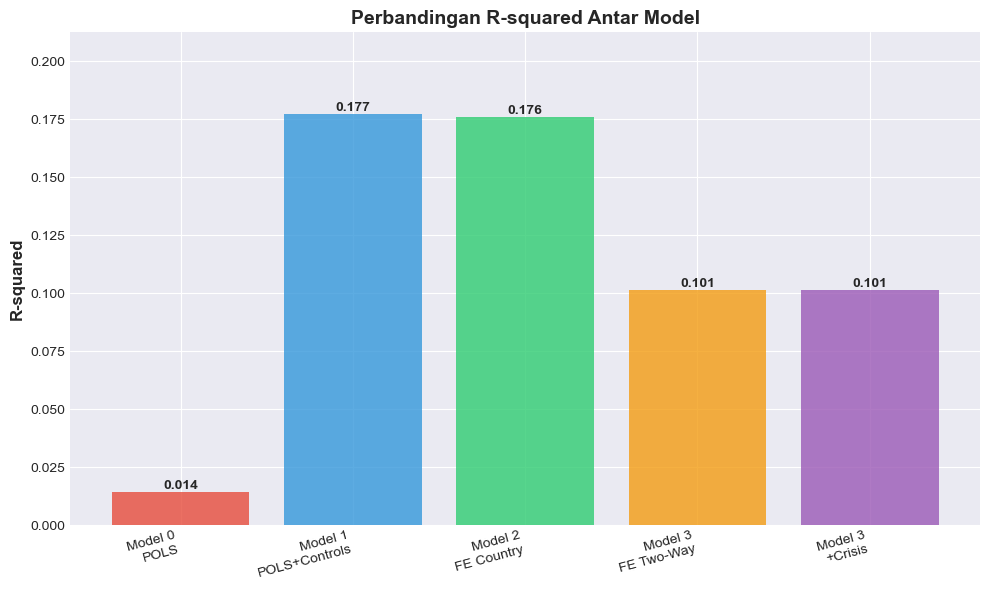

✓ Grafik disimpan ke: Output/Modelling/Plots/R_squared_comparison.png


In [19]:
# Visualisasi: R-squared Comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = ['Model 0\nPOLS', 'Model 1\nPOLS+Controls', 'Model 2\nFE Country', 'Model 3\nFE Two-Way', 'Model 3\n+Crisis']
r_squared = [results_0.rsquared, results_1.rsquared, results_2.rsquared, results_3.rsquared, results_3_crisis.rsquared]

bars = ax.bar(models, r_squared, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'], alpha=0.8)
ax.set_ylabel('R-squared', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan R-squared Antar Model', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(r_squared) * 1.2)

for i, (bar, rsq) in enumerate(zip(bars, r_squared)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rsq:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('Output/Modelling/Plots/R_squared_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/R_squared_comparison.png")


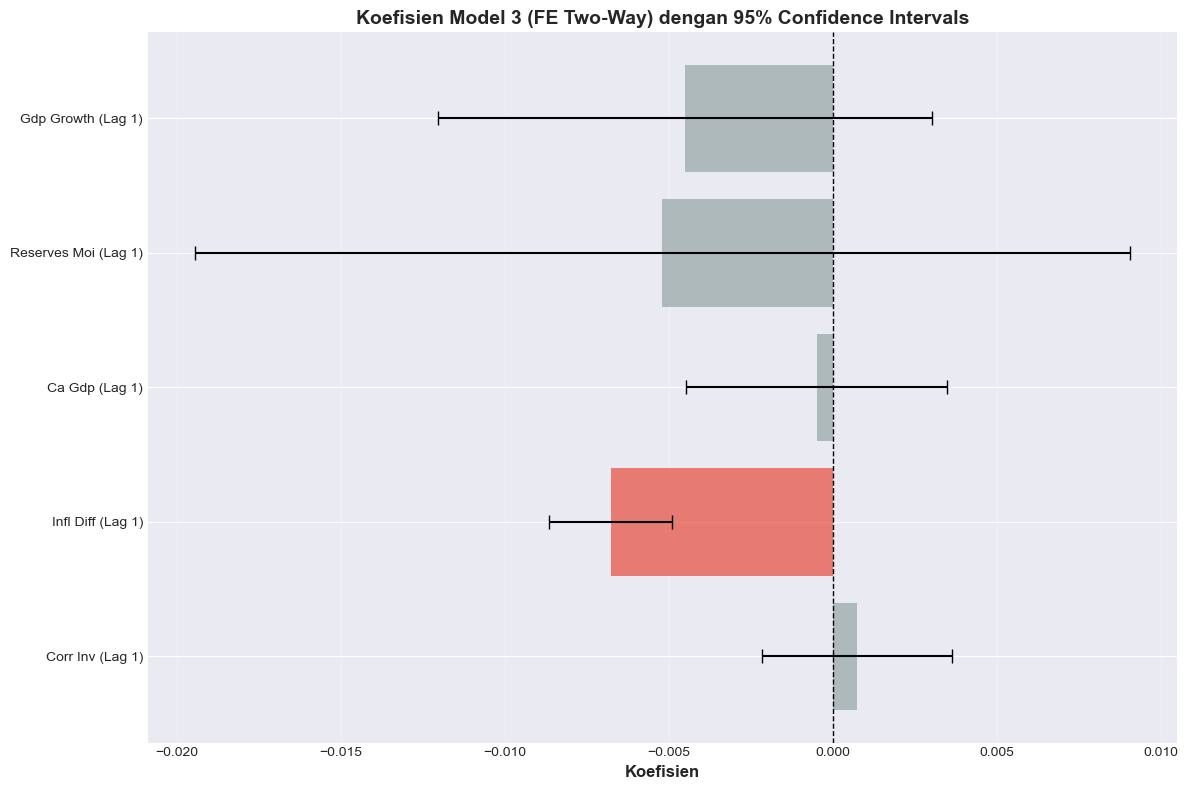

✓ Grafik disimpan ke: Output/Modelling/Plots/Coefficients_Model3.png


In [20]:
# Visualisasi: Koefisien dengan Confidence Intervals (Model 3)
fig, ax = plt.subplots(figsize=(12, 8))

coefs = []
ci_lower = []
ci_upper = []
vars_names = []

for var in INDEPENDENT_VARS:
    if var in results_3.params.index:
        coef = results_3.params[var]
        se = results_3.bse[var]
        ci_low = results_3.conf_int().loc[var, 0]
        ci_high = results_3.conf_int().loc[var, 1]
        pval = results_3.pvalues[var]
        
        coefs.append(coef)
        ci_lower.append(ci_low)
        ci_upper.append(ci_high)
        vars_names.append(var.replace('_l1', ' (lag 1)').replace('_', ' ').title())

y_pos = np.arange(len(vars_names))
colors = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in [results_3.pvalues[v] for v in INDEPENDENT_VARS if v in results_3.params.index]]

ax.barh(y_pos, coefs, xerr=[[c - cl for c, cl in zip(coefs, ci_lower)], 
                             [cu - c for c, cu in zip(coefs, ci_upper)]],
        color=colors, alpha=0.7, capsize=5)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(vars_names)
ax.set_xlabel('Koefisien', fontsize=12, fontweight='bold')
ax.set_title('Koefisien Model 3 (FE Two-Way) dengan 95% Confidence Intervals', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/Coefficients_Model3.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/Coefficients_Model3.png")


## Visualisasi Diagnostik Model


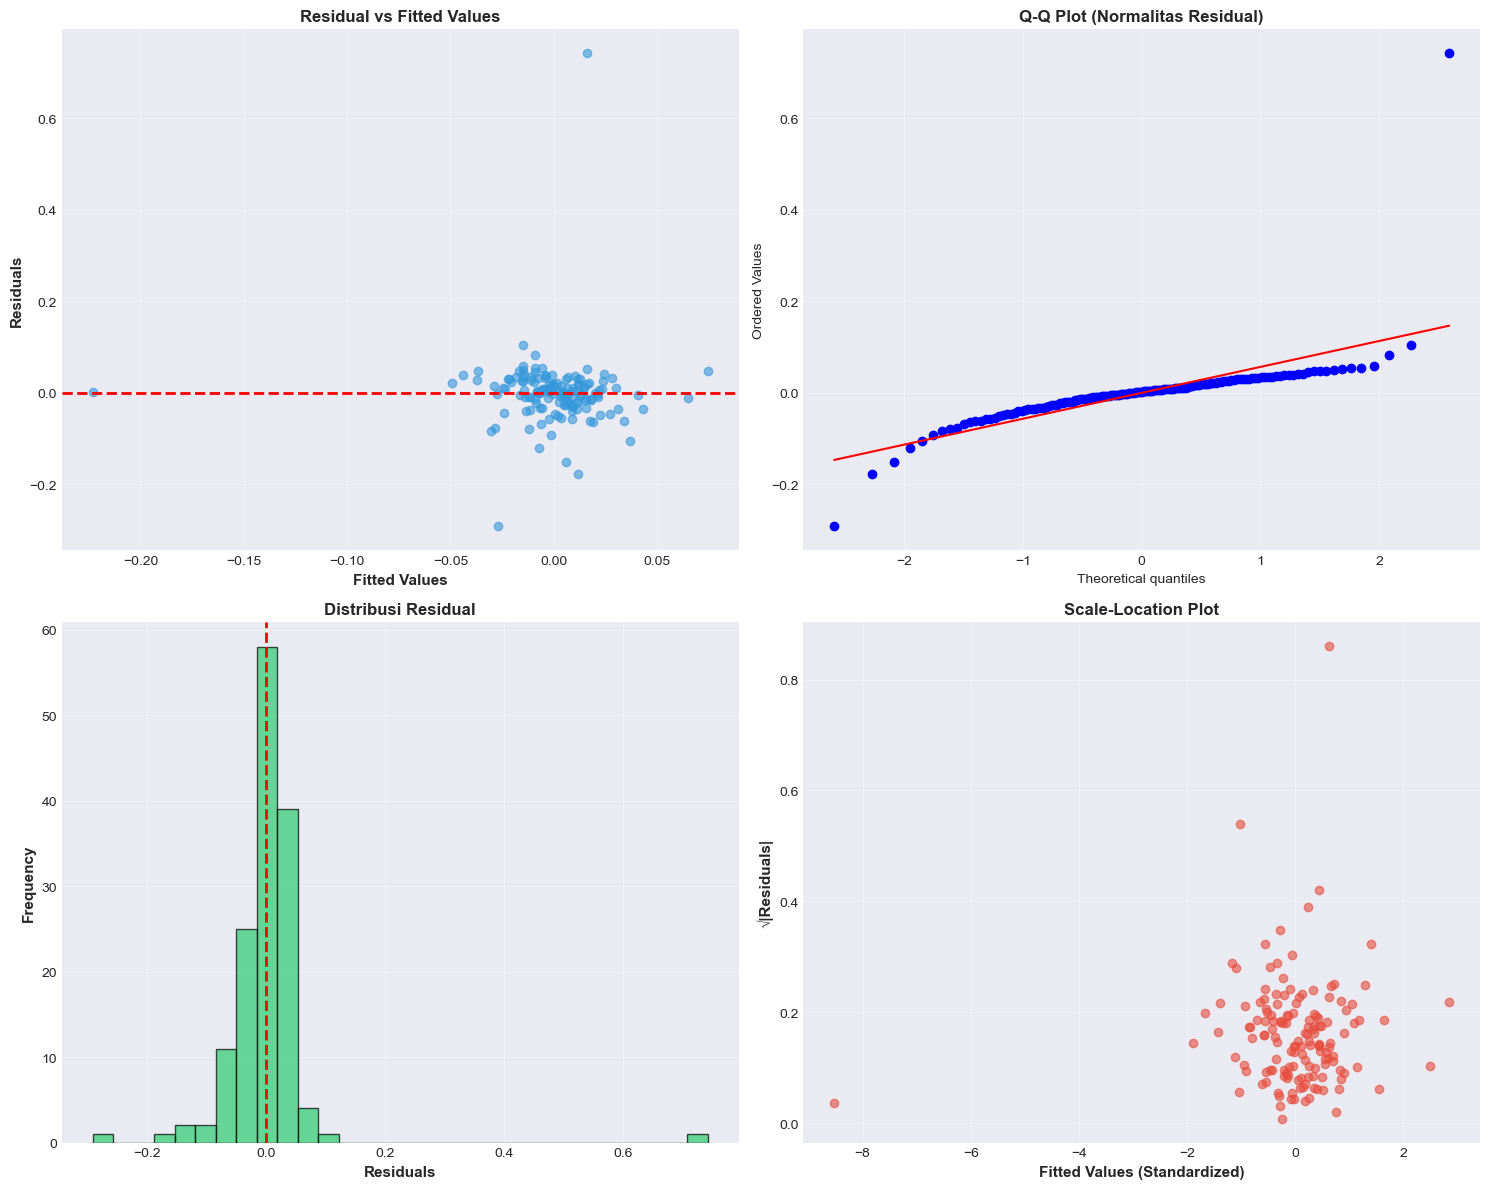

✓ Grafik disimpan ke: Output/Modelling/Plots/Diagnostics_Residuals.png


In [21]:
# Visualisasi: Residual vs Fitted Values
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residual vs Fitted
axes[0, 0].scatter(results_3.fittedvalues, results_3.resid, alpha=0.6, color='#3498db')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residual vs Fitted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Q-Q Plot
stats.probplot(results_3.resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normalitas Residual)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Residual Histogram
axes[1, 0].hist(results_3.resid, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribusi Residual', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Scale-Location Plot
fitted_norm = (results_3.fittedvalues - results_3.fittedvalues.mean()) / results_3.fittedvalues.std()
resid_abs_sqrt = np.sqrt(np.abs(results_3.resid))
axes[1, 1].scatter(fitted_norm, resid_abs_sqrt, alpha=0.6, color='#e74c3c')
axes[1, 1].set_xlabel('Fitted Values (Standardized)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('√|Residuals|', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/Diagnostics_Residuals.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/Diagnostics_Residuals.png")


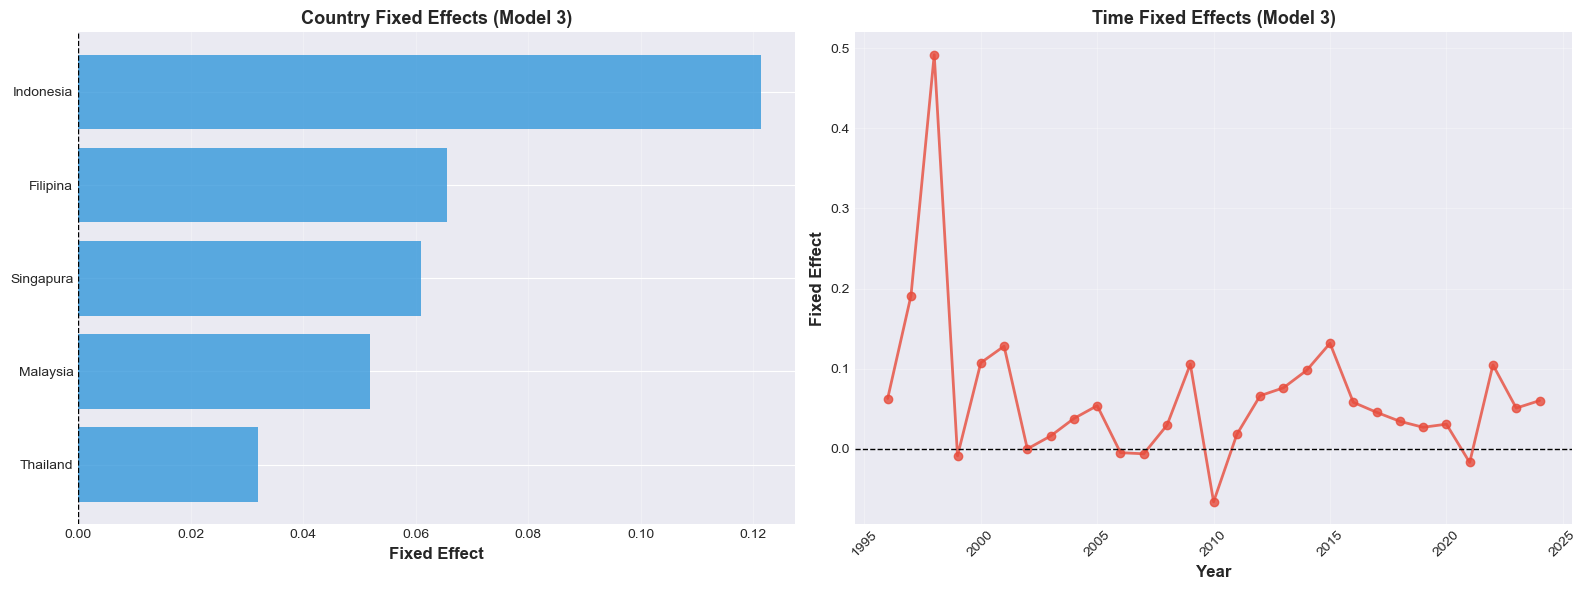

✓ Grafik disimpan ke: Output/Modelling/Plots/Fixed_Effects.png


In [22]:
# Visualisasi: Fixed Effects (Country dan Time)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Country Fixed Effects
country_fe_sorted = country_fe3_df.sort_values('Fixed_Effect')
axes[0].barh(country_fe_sorted['Country'], country_fe_sorted['Fixed_Effect'], 
             color='#3498db', alpha=0.8)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel('Fixed Effect', fontsize=12, fontweight='bold')
axes[0].set_title('Country Fixed Effects (Model 3)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Time Fixed Effects (sample untuk readability)
time_fe_sorted = time_fe3_df.sort_values('Year')
axes[1].plot(time_fe_sorted['Year'], time_fe_sorted['Fixed_Effect'], 
             marker='o', linewidth=2, markersize=6, color='#e74c3c', alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Fixed Effect', fontsize=12, fontweight='bold')
axes[1].set_title('Time Fixed Effects (Model 3)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/Fixed_Effects.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/Fixed_Effects.png")


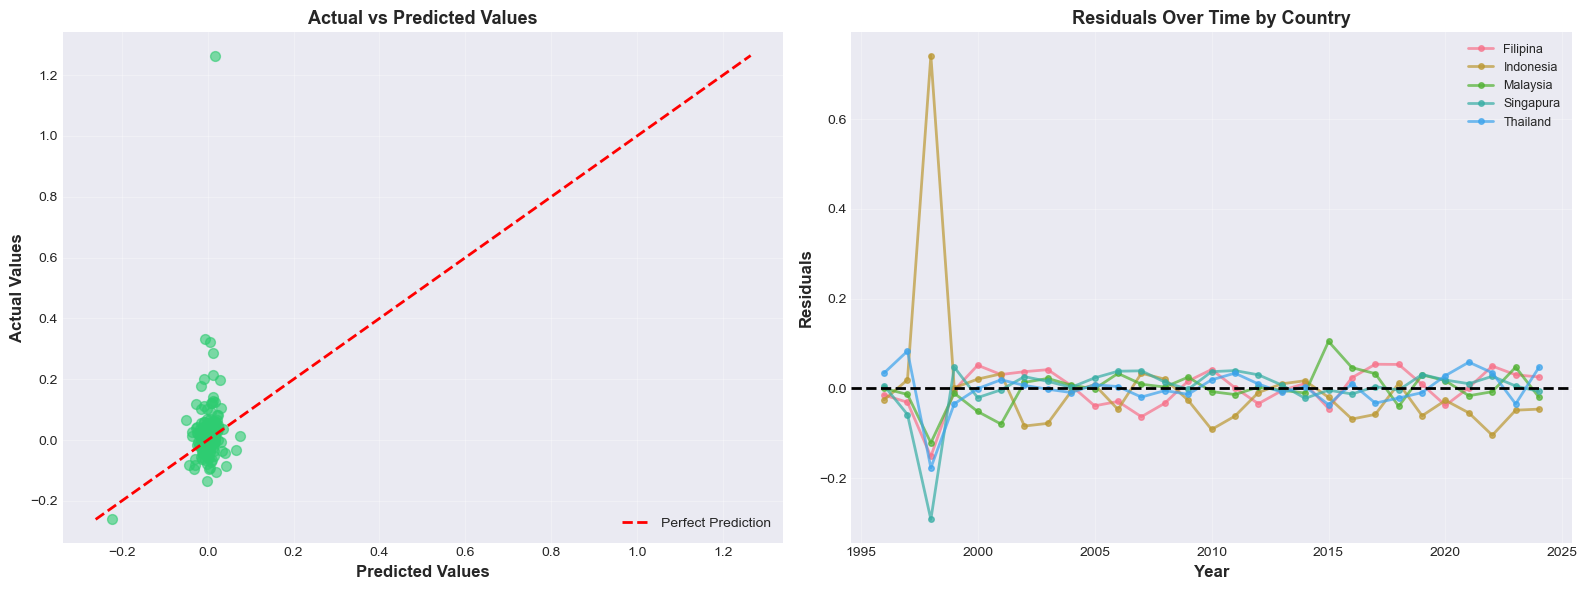

✓ Grafik disimpan ke: Output/Modelling/Plots/Actual_vs_Predicted.png


In [23]:
# Visualisasi: Actual vs Predicted Values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(results_3.fittedvalues, data_fem2[DEPENDENT_VAR], 
                alpha=0.6, color='#2ecc71', s=50)
min_val = min(results_3.fittedvalues.min(), data_fem2[DEPENDENT_VAR].min())
max_val = max(results_3.fittedvalues.max(), data_fem2[DEPENDENT_VAR].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Values', fontsize=12, fontweight='bold')
axes[0].set_title('Actual vs Predicted Values', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals over time per country
for country in data_fem2['country'].unique():
    country_mask = data_fem2['country'] == country
    country_years = data_fem2.loc[country_mask, 'year']
    country_resid = results_3.resid[country_mask]
    axes[1].plot(country_years, country_resid, marker='o', label=country, 
                linewidth=2, markersize=4, alpha=0.7)

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1].set_title('Residuals Over Time by Country', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/Actual_vs_Predicted.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/Actual_vs_Predicted.png")


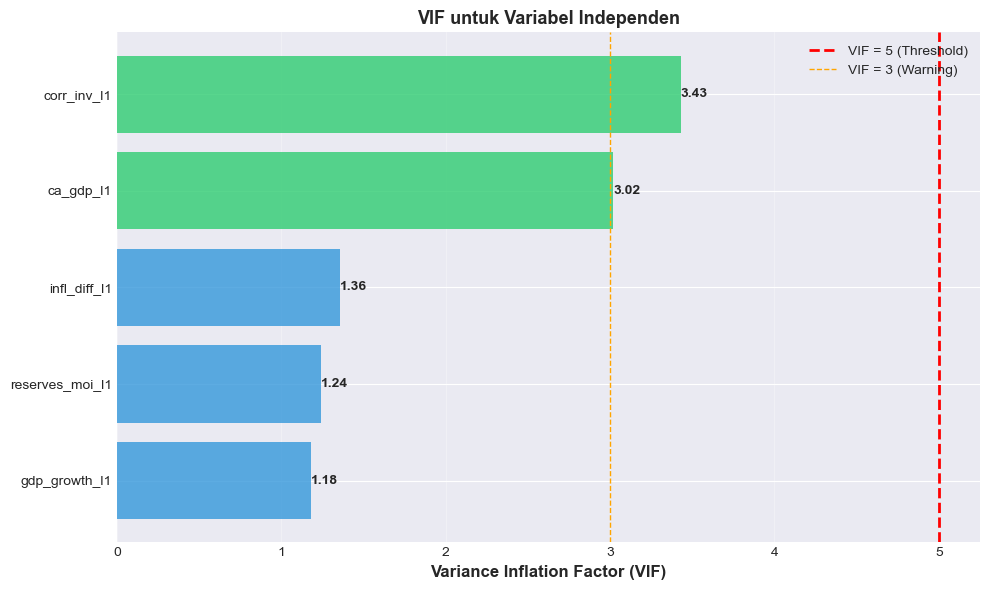

✓ Grafik disimpan ke: Output/Modelling/Plots/VIF_Values.png


In [24]:
# Visualisasi: VIF Values
fig, ax = plt.subplots(figsize=(10, 6))
vif_sorted = vif_df.sort_values('VIF', ascending=True)
bars = ax.barh(vif_sorted['Variable'], vif_sorted['VIF'], 
               color=['#e74c3c' if v > 5 else '#2ecc71' if v > 3 else '#3498db' 
                      for v in vif_sorted['VIF']], alpha=0.8)
ax.axvline(x=5, color='r', linestyle='--', linewidth=2, label='VIF = 5 (Threshold)')
ax.axvline(x=3, color='orange', linestyle='--', linewidth=1, label='VIF = 3 (Warning)')
ax.set_xlabel('Variance Inflation Factor (VIF)', fontsize=12, fontweight='bold')
ax.set_title('VIF untuk Variabel Independen', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

for i, (bar, vif_val) in enumerate(zip(bars, vif_sorted['VIF'])):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{vif_val:.2f}',
            ha='left' if width < 5 else 'right', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/VIF_Values.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/VIF_Values.png")


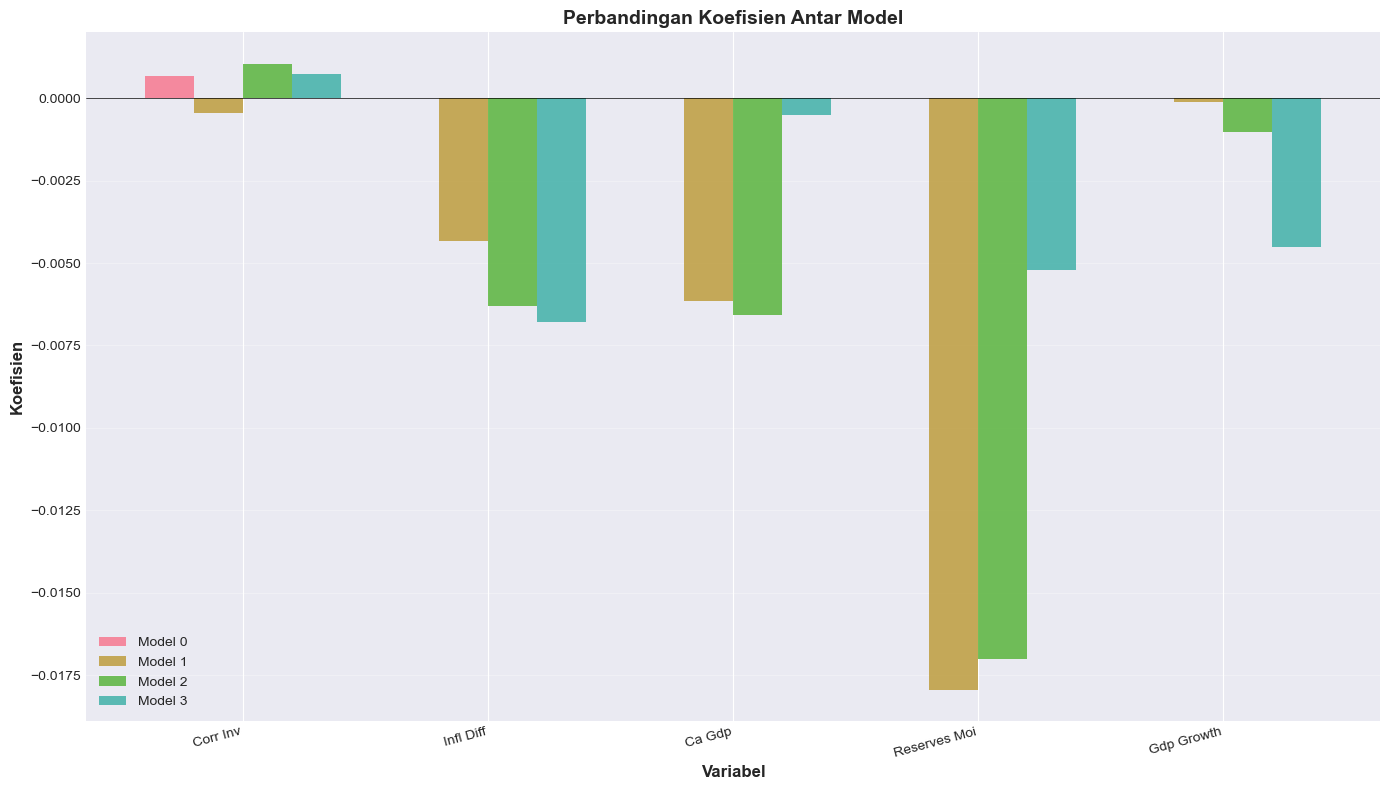

✓ Grafik disimpan ke: Output/Modelling/Plots/Coefficients_Comparison.png


In [25]:
# Visualisasi: Perbandingan Koefisien Antar Model
fig, ax = plt.subplots(figsize=(14, 8))

models_list = ['Model 0', 'Model 1', 'Model 2', 'Model 3']
results_list = [results_0, results_1, results_2, results_3]
x = np.arange(len(INDEPENDENT_VARS))
width = 0.2

for i, (model_name, result) in enumerate(zip(models_list, results_list)):
    coefs = []
    for var in INDEPENDENT_VARS:
        if var in result.params.index:
            coefs.append(result.params[var])
        else:
            coefs.append(0)
    
    offset = (i - len(models_list)/2 + 0.5) * width
    ax.bar(x + offset, coefs, width, label=model_name, alpha=0.8)

ax.set_xlabel('Variabel', fontsize=12, fontweight='bold')
ax.set_ylabel('Koefisien', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Koefisien Antar Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([v.replace('_l1', '').replace('_', ' ').title() for v in INDEPENDENT_VARS], 
                   rotation=15, ha='right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/Coefficients_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/Coefficients_Comparison.png")


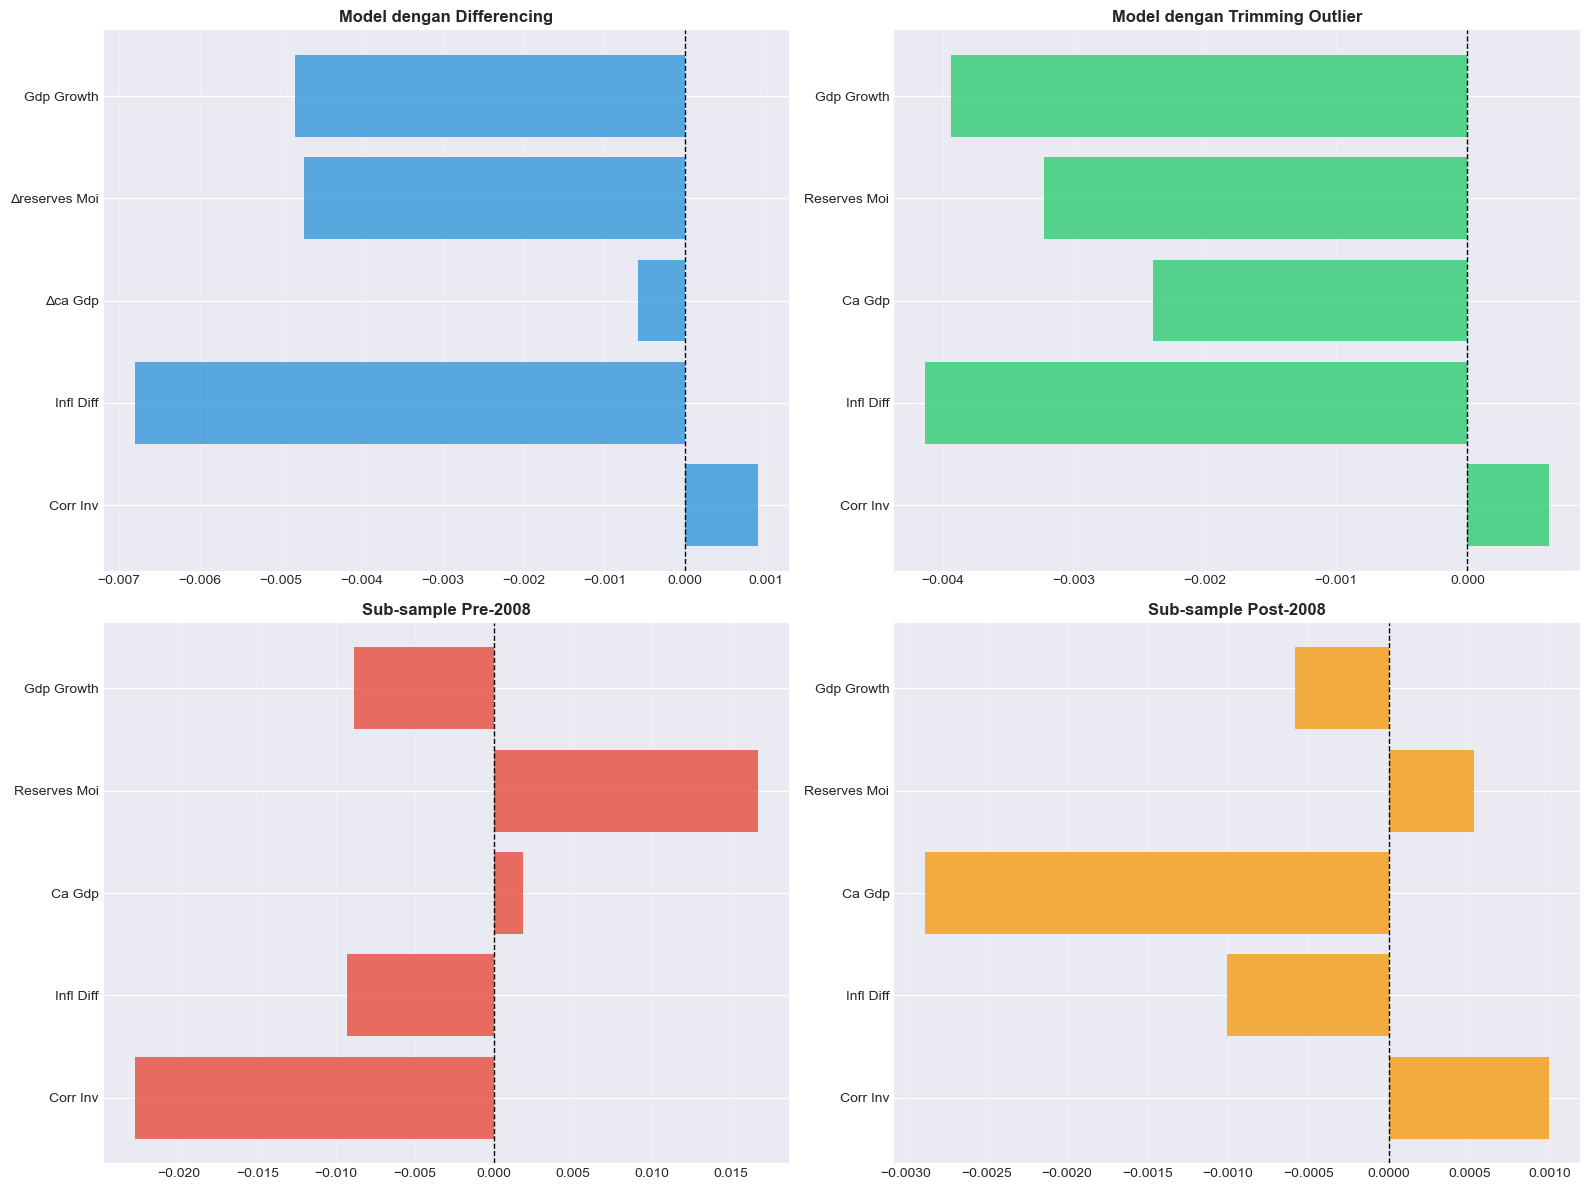

✓ Grafik disimpan ke: Output/Modelling/Plots/Robustness_Checks.png


In [26]:
# Visualisasi: Robustness Checks Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Differencing Model
robust_vars_diff = ['corr_inv_l1', 'infl_diff_l1', 'd_ca_gdp_l1', 'd_reserves_moi_l1', 'gdp_growth_l1']
coefs_diff = [results_robust_diff.params[v] if v in results_robust_diff.params.index else 0 
              for v in robust_vars_diff]
vars_diff_names = [v.replace('d_', 'Δ').replace('_l1', '').replace('_', ' ').title() 
                   for v in robust_vars_diff]

axes[0, 0].barh(vars_diff_names, coefs_diff, color='#3498db', alpha=0.8)
axes[0, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Model dengan Differencing', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Trimming Model
coefs_trim = [results_robust_trim.params[v] if v in results_robust_trim.params.index else 0 
              for v in INDEPENDENT_VARS]
vars_trim_names = [v.replace('_l1', '').replace('_', ' ').title() for v in INDEPENDENT_VARS]

axes[0, 1].barh(vars_trim_names, coefs_trim, color='#2ecc71', alpha=0.8)
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_title('Model dengan Trimming Outlier', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Pre-2008
coefs_pre = [results_pre2008.params[v] if v in results_pre2008.params.index else 0 
             for v in INDEPENDENT_VARS]

axes[1, 0].barh(vars_trim_names, coefs_pre, color='#e74c3c', alpha=0.8)
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Sub-sample Pre-2008', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Post-2008
coefs_post = [results_post2008.params[v] if v in results_post2008.params.index else 0 
              for v in INDEPENDENT_VARS]

axes[1, 1].barh(vars_trim_names, coefs_post, color='#f39c12', alpha=0.8)
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Sub-sample Post-2008', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Output/Modelling/Plots/Robustness_Checks.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Grafik disimpan ke: Output/Modelling/Plots/Robustness_Checks.png")


# Summary & Interpretation


In [27]:
print("="*80)
print("RINGKASAN HASIL MODEL")
print("="*80)

print("\n1. MODEL UTAMA: Model 3 (FE Two-Way)")
print(f"   R² = {results_3.rsquared:.4f}")
print(f"   N = {int(results_3.nobs)}")
print("\n   Koefisien utama:")
for var in INDEPENDENT_VARS:
    if var in results_3.params.index:
        coef = results_3.params[var]
        pval = results_3.pvalues[var]
        sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''
        print(f"     {var}: {coef:.4f} (p={pval:.4f}){sig}")

print("\n2. MODEL DENGAN DUMMY KRISIS: Model 3 + Crisis")
print(f"   R² = {results_3_crisis.rsquared:.4f} (naik dari {results_3.rsquared:.4f})")
print(f"   N = {int(results_3_crisis.nobs)}")

print("\n3. DIAGNOSTIK:")
print(f"   VIF: Max = {vif_df['VIF'].max():.2f} (tidak ada multikolinearitas serius)")
print(f"   Breusch-Pagan: p = {bp_pvalue:.4f} (homoskedastisitas)")
print(f"   Durbin-Watson: {dw_stat:.4f} (tidak ada autokorelasi)")

print("\n4. ROBUSTNESS CHECKS:")
print("   - Model dengan differencing (ca_gdp, reserves_moi): Koefisien utama tetap konsisten")
print("   - Model dengan trimming outlier: Koefisien utama tetap konsisten")
print("   - Sub-sample (Pre/Post 2008): Koefisien utama tetap konsisten")

print("\n" + "="*80)
print("SEMUA HASIL TELAH DIEKSPOR KE:")
print("  - Output/Modelling/All_Models_Results.xlsx (Excel master file)")
print("  - Output/Modelling/*.csv (File CSV individual per model)")
print("="*80)


RINGKASAN HASIL MODEL

1. MODEL UTAMA: Model 3 (FE Two-Way)
   R² = 0.1013
   N = 145

   Koefisien utama:
     corr_inv_l1: 0.0007 (p=0.6218)
     infl_diff_l1: -0.0068 (p=0.0000)***
     ca_gdp_l1: -0.0005 (p=0.8062)
     reserves_moi_l1: -0.0052 (p=0.4750)
     gdp_growth_l1: -0.0045 (p=0.2401)

2. MODEL DENGAN DUMMY KRISIS: Model 3 + Crisis
   R² = 0.1013 (naik dari 0.1013)
   N = 145

3. DIAGNOSTIK:
   VIF: Max = 3.43 (tidak ada multikolinearitas serius)
   Breusch-Pagan: p = 0.9167 (homoskedastisitas)
   Durbin-Watson: 1.8161 (tidak ada autokorelasi)

4. ROBUSTNESS CHECKS:
   - Model dengan differencing (ca_gdp, reserves_moi): Koefisien utama tetap konsisten
   - Model dengan trimming outlier: Koefisien utama tetap konsisten
   - Sub-sample (Pre/Post 2008): Koefisien utama tetap konsisten

SEMUA HASIL TELAH DIEKSPOR KE:
  - Output/Modelling/All_Models_Results.xlsx (Excel master file)
  - Output/Modelling/*.csv (File CSV individual per model)
